<a href="https://colab.research.google.com/github/shaghayegh5ghasemi/supervised_fuzzy_clustering/blob/main/Supervised_Fuzzy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

In [ ]:
# load data
trainset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(dataset=trainset, batch_size=1, shuffle=True)
testset = datasets.CIFAR10(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dataset keeps our windows, class_label_matrix keeps the label of windows
dataset = []
class_label_matrix = []

# centroid and cov of each cluster
centroids = []
covariances = []
inverted_covariances = []

# initialize the centroids and the parameters
number_of_dimensions = 27
number_of_classes = len(classes)

gamma = 1
sigma = 0.5
threshold = 0.03
beta = 1

In [ ]:
# plot the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def make_window(dataset, class_label_matrix, img, label, number_of_classes):
  windows = img.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
  for i in range(15):
    for j in range(15):
      dataset.append(windows[:, i, j].reshape(27))
      temp = [0]*number_of_classes
      temp[label] = 1
      class_label_matrix.append(temp)

In [ ]:
def make_dataset(dataset, class_label_matrix):
  c = [0]*10
  for i, (inputs, labels) in enumerate(trainloader):
    if all(x == 10 for x in c):
      break
    if c[labels[0]] == 10:
      continue
    else:
      c[labels[0]] += 1
      make_window(dataset, class_label_matrix, inputs[0], labels[0], 10)

In [ ]:
make_dataset(dataset, class_label_matrix)
dataset = torch.stack(dataset)
dataset = dataset.type(torch.DoubleTensor)
class_label_matrix = torch.tensor(class_label_matrix, dtype=torch.float64)

In [ ]:
def initialize_centroids(dataset, centroids, inverted_covariances, covariances, gamma, sigma, threshold, number_of_dimensions):
  number_of_centroids = 0
  for data in dataset:
    if number_of_centroids == 0:
      number_of_centroids += 1
      centroids.append(data)
      covariances.append(sigma*torch.eye(number_of_dimensions, dtype=torch.float64))
      inverted_covariances.append(torch.eye(number_of_dimensions, dtype=torch.float64)/sigma)
    else:
      temp = torch.stack(centroids)
      xc = data-temp
      distances = []
      for i in range(len(centroids)):
        distances.append(xc[i].reshape((1, number_of_dimensions))@inverted_covariances[i]@torch.transpose(xc[i].reshape((1, number_of_dimensions)), 0, 1))
      distances = -1*gamma*torch.tensor(distances)
      RM = torch.exp(distances)
      if max(RM) < threshold:
        number_of_centroids += 1
        centroids.append(data)
        covariances.append(sigma*torch.eye(number_of_dimensions, dtype=torch.float64))
        inverted_covariances.append(torch.eye(number_of_dimensions, dtype=torch.float64)/sigma)

In [ ]:
initialize_centroids(dataset, centroids, inverted_covariances, covariances, gamma, sigma, threshold, number_of_dimensions)
q = torch.zeros((len(centroids), number_of_classes), dtype=torch.float64) # matrix that contains the probibilities number of clusters x number of classes

In [ ]:
print(len(centroids))

31


In [ ]:
from torch.nn.functional import normalize
def calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma, number_of_dimensions):
  list_RM = []
  for i in range(len(centroids)):
    xc = dataset-centroids[i]
    temp = ((xc@inverted_covariances[i])*xc)@torch.ones((number_of_dimensions, 1), dtype=torch.float64)
    mem = torch.exp(-1*gamma*temp)
    list_RM.append(mem)
  #normalize the matirx
  RM = torch.cat(list_RM, dim=1)
  miu_ik = normalize(RM, p=1.0, dim = 1)
  return miu_ik

In [ ]:
def update_centroids(dataset, centroids, inverted_covariances, q, gamma, beta, number_of_dimensions):
  updated_centroid = []
  miu_ik = calculate_membership_matrix(dataset , centroids, inverted_covariances, gamma, number_of_dimensions)
  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = torch.sum(temp, 0).reshape((1, len(class_label_matrix[0]))) 
    q[i, :] = cnt/torch.sum(cnt)
    temp2 = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset), 1])*miu_ik[:, [i]]
    temp3 = torch.transpose(temp2, 0, 1)@dataset
    updated_centroid.append((1-beta)*centroids[i] + beta*(temp3)/torch.sum(temp2))
  return updated_centroid

In [ ]:
def update_covariances(dataset, centroids, covariances, inverted_covariances, q, classes, gamma, beta, tr, number_of_dimensions):
  miu_ik = calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma, number_of_dimensions)
  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = torch.sum(temp, 0).reshape((1, len(class_label_matrix[0]))) 
    q[i, :] = cnt/torch.sum(cnt)
    temp2 = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset), 1])*miu_ik[:, [i]]

    x_clusteri = dataset - centroids[i]
    temp3 = torch.transpose(temp2*x_clusteri, 0, 1)@x_clusteri
    covariances[i] = (1-beta)*covariances[i] + beta*temp3/torch.sum(temp2)
    inverted_covariances[i] = torch.linalg.pinv(covariances[i], tr)

In [ ]:
def calculate_entropy(dataset, centroids, inverted_covariances, classes, q, gamma):
  ent = -1*torch.sum(torch.mean(q*torch.log(q + 0.1), 0), axis=0)
  return ent

In [ ]:
entropy_curve = []
for i in range(300):
  centroids = update_centroids(dataset, centroids, inverted_covariances, q, gamma, beta, number_of_dimensions)
  update_covariances(dataset, centroids, covariances, inverted_covariances, q, classes, gamma, beta, 0.5, number_of_dimensions)
  entropy = calculate_entropy(dataset, centroids, inverted_covariances, classes, q, gamma)
  entropy_curve.append(entropy)
  print(entropy)

tensor(1.5799, dtype=torch.float64)
tensor(1.5743, dtype=torch.float64)
tensor(1.5686, dtype=torch.float64)
tensor(1.5748, dtype=torch.float64)
tensor(1.5868, dtype=torch.float64)
tensor(1.5904, dtype=torch.float64)
tensor(1.5846, dtype=torch.float64)
tensor(1.5827, dtype=torch.float64)
tensor(1.5894, dtype=torch.float64)
tensor(1.5845, dtype=torch.float64)
tensor(1.5835, dtype=torch.float64)
tensor(1.5908, dtype=torch.float64)
tensor(1.5970, dtype=torch.float64)
tensor(1.5998, dtype=torch.float64)
tensor(1.5952, dtype=torch.float64)
tensor(1.5933, dtype=torch.float64)
tensor(1.5935, dtype=torch.float64)
tensor(1.5897, dtype=torch.float64)
tensor(1.5930, dtype=torch.float64)
tensor(1.5953, dtype=torch.float64)
tensor(1.6010, dtype=torch.float64)
tensor(1.5982, dtype=torch.float64)
tensor(1.5987, dtype=torch.float64)
tensor(1.5982, dtype=torch.float64)
tensor(1.5963, dtype=torch.float64)
tensor(1.5888, dtype=torch.float64)
tensor(1.5938, dtype=torch.float64)
tensor(1.5955, dtype=torch.f

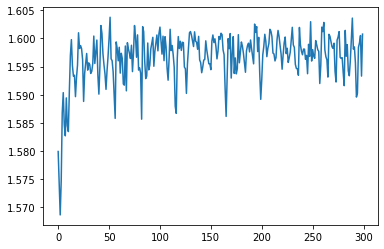

In [ ]:
import matplotlib.pyplot as plt
plt.plot(entropy_curve)
plt.show()

In [ ]:
def calculate_mahanalobis_distance(icm, m, x):
  # D^2 = (x-m)^T * C^-1 * (x-m), mahanalobis distance formula
  s = x.reshape((27, 1))-m.reshape((27, 1))
  return torch.transpose(s, 0, 1)@icm@s

In [ ]:
def calculate_membership(icm, vi, x, gamma):
  distance = calculate_mahanalobis_distance(icm, vi, x)
  # if torch.exp(-1*gamma*distance) < 0.0001:
  #   return torch.array(0.0001)
  # else:
  return torch.exp(-1*gamma*distance)

  b i r d


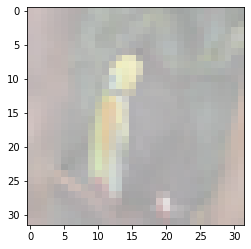

window number 1 belongs to cluster 9
window number 2 belongs to cluster 10
window number 3 belongs to cluster 28
window number 4 belongs to cluster 14
window number 5 belongs to cluster 14
window number 6 belongs to cluster 14
window number 7 belongs to cluster 14
window number 8 belongs to cluster 7
window number 9 belongs to cluster 14
window number 10 belongs to cluster 14
window number 11 belongs to cluster 14
window number 12 belongs to cluster 1
window number 13 belongs to cluster 14
window number 14 belongs to cluster 14
window number 15 belongs to cluster 14
window number 16 belongs to cluster 15
window number 17 belongs to cluster 10
window number 18 belongs to cluster 28
window number 19 belongs to cluster 14
window number 20 belongs to cluster 14
window number 21 belongs to cluster 14
window number 22 belongs to cluster 14
window number 23 belongs to cluster 14
window number 24 belongs to cluster 14
window number 25 belongs to cluster 14
window number 26 belongs to cluster 1

In [ ]:
label = torch.tensor(12)
for i, (inputs, labels) in enumerate(testloader):
  if label != torch.tensor(12):
    break
  if labels[0] in [torch.tensor(0), torch.tensor(1), torch.tensor(2)]:
    image = inputs[0]
    label = labels[0]
print(' '.join('%5s' % classes[label]))
imshow(torchvision.utils.make_grid(image))

windows = image.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
test = []
for i in range(15):
  for j in range(15): 
    test.append(windows[:, i, j].reshape(27))

windows_max_membership = []
for w in test:
  memberships = []
  for i in range(len(centroids)):
    memberships.append(calculate_membership(inverted_covariances[i], centroids[i], w, gamma))
  test = torch.tensor(memberships)
  windows_max_membership.append(torch.argmax(test))


for i in range(len(test)):
  print(f'window number {i+1} belongs to cluster {windows_max_membership[i] + 1}')
  


In [ ]:
print(centroids)

[tensor([[0.8456, 0.8429, 0.8405, 0.8427, 0.8402, 0.8389, 0.8340, 0.8335, 0.8311,
         0.8654, 0.8627, 0.8602, 0.8626, 0.8602, 0.8585, 0.8524, 0.8517, 0.8490,
         0.8853, 0.8826, 0.8800, 0.8816, 0.8793, 0.8776, 0.8694, 0.8688, 0.8659]]), tensor([[0.6317, 0.6577, 0.6315, 0.5554, 0.6149, 0.6224, 0.5406, 0.5541, 0.5678,
         0.6214, 0.6491, 0.6237, 0.5452, 0.6072, 0.6139, 0.5316, 0.5468, 0.5592,
         0.6139, 0.6427, 0.6171, 0.5325, 0.5962, 0.6041, 0.5157, 0.5328, 0.5464]]), tensor([[0.2639, 0.2677, 0.2722, 0.2667, 0.2712, 0.2737, 0.2700, 0.2737, 0.2777,
         0.2216, 0.2260, 0.2301, 0.2255, 0.2303, 0.2321, 0.2295, 0.2335, 0.2364,
         0.2290, 0.2334, 0.2367, 0.2313, 0.2365, 0.2378, 0.2328, 0.2371, 0.2391]]), tensor([[0.5621, 0.5615, 0.5601, 0.5633, 0.5625, 0.5615, 0.5616, 0.5627, 0.5621,
         0.5621, 0.5613, 0.5601, 0.5631, 0.5621, 0.5612, 0.5611, 0.5621, 0.5615,
         0.5552, 0.5540, 0.5525, 0.5558, 0.5544, 0.5531, 0.5533, 0.5539, 0.5530]]), tensor([[0.4291

# old cells

In [ ]:
def calculate_mahanalobis_distance(icm, m, x, number_of_dimensions):
  # D^2 = (x-m)^T * C^-1 * (x-m), mahanalobis distance formula
  s = x.reshape((number_of_dimensions, 1))-m.reshape((number_of_dimensions, 1))
  return torch.transpose(s, 0, 1)@icm@s

In [ ]:
from torch.nn.functional import normalize
def calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma, number_of_dimensions):
  RM = torch.zeros((len(dataset), len(centroids)), dtype=torch.float62) # matrix that contains the memberships number of samples x number of clusters
  for i in range(len(centroids)):
    xc = dataset-centroids[i]
    temp = ((xc@inverted_covariances[i])*xc)@torch.ones((number_of_dimensions, 1))
    mem = torch.exp(-1*gamma*temp)
    RM[:, i] = mem[:, 0]
  #normalize the matirx
  miu_ik = normalize(RM, p=1.0, dim = 1)
  return miu_ik
